<a href="https://colab.research.google.com/github/yimusad/amazon-recommender-system/blob/main/Team3_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## DSCI 351: Recommender Systems
### Final Project Report
Due: Wednesday, September 6
---

**Amazon Electronic Products Recommendation System**

Team 3:
1. Yara Musad
2. Kelsey Chong
3. Jason Le

All our project related work and datasets can be found here: https://drive.google.com/drive/folders/1sF-n6LORteXJ__le6wOljRLa1j4dNXWv


In [ ]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=2811605 sha256=99adff60ba83f5e63660e8f149b6d98763b9cfe83ec57cfac0a8ed37a2abb005
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

# split
from sklearn.model_selection import train_test_split

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [ ]:
# mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
ratings_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/DSCI351/Final Project/ratings_Electronics.csv",
             names=['userId', 'productId','rating','timestamp'])


## 1. **Introduction**
---

**Background:**

Online shopping has become an integral part of our lives, offering a convenient alternative to traditional brick-and-mortar stores. Amazon, a leading e-commerce platform, provides a wide variety of products, including electronics. However, the abundance of choices can often be overwhelming for consumers. That's where recommendation systems come into play. They filter product options and personalize the shopping experience based on individual customer behavior, thereby helping both consumers in decision-making and businesses in enhancing customer engagement.

**Problem Statement:**

While there are existing recommendation systems in place, many of them operate either on a purely content-based or collaborative filtering basis. Each approach has its own set of limitations—content-based methods often suffer from the 'filter bubble' phenomenon, while collaborative filtering methods struggle with the 'cold start' problem. Additionally, the vast and sparse datasets generated by Amazon's extensive user and product base present challenges that are computational as well as algorithmic.

**Goal**:

Conduct exploratory data analysis (EDA) to understand the characteristics of Amazon's electronic product reviews and ratings.
Implement a model-based collaborative filtering recommendation system using machine learning algorithms.
Evaluate the model's performance using metrics like RMSE (Root Mean Square Error) and MAE (Mean Absolute Error).
Provide insights into how this model can be deployed and scaled effectively to improve user experience and engagement.

**Methodology:**

To accomplish the objectives, this project will leverage Python's data science ecosystem, including libraries like Pandas for data manipulation, Matplotlib and Seaborn for data visualization, and Scikit-Surprise for building the recommendation algorithm.

We will leverage User-based, Item-based and Model-based Collaborative Filtering methods.

The dataset consists of Amazon electronic product reviews, capturing various attributes such as user ID, product ID, ratings, and timestamps.


####  About the Dataset

The dataset contians for electronci products reviews on amazon.

Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/)

Attribute Information:

- userId : Every user identified with a unique id (First Column)
- productId : Every product identified with a unique id(Second Column)
- Rating : Rating of the corresponding product by the corresponding user(Third Column)
- timestamp : Time of the rating ( Fourth Column)

## Exploratory Data Analysis
---

In [ ]:
ratings_df.head()

,userId,productId,rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
print("Total Reviews:",ratings_df.shape[0])
print("Total Columns:",ratings_df.shape[1])

Total Reviews: 7824482
Total Columns: 4


In [ ]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 238.8+ MB


In [ ]:
# no missing values
ratings_df.isnull().sum()

userId       0
productId    0
rating       0
timestamp    0
dtype: int64

In [ ]:
# no duplicate values
ratings_df[ratings_df.duplicated()].any()

userId       False
productId    False
rating       False
timestamp    False
dtype: bool

In [ ]:
# subset the dataset
ratings_df = ratings_df.iloc[:300000,0:]

# look at relevant metrics
print("Total number of ratings :",ratings_df.rating.nunique())
print("Total number of users   :", ratings_df.userId.nunique())
print("Total number of products  :", ratings_df.productId.nunique())
print("Unique value of Rating:",ratings_df.rating.unique())

Total number of ratings : 5
Total number of users   : 252385
Total number of products  : 18894
Unique value of Rating: [5. 1. 3. 2. 4.]


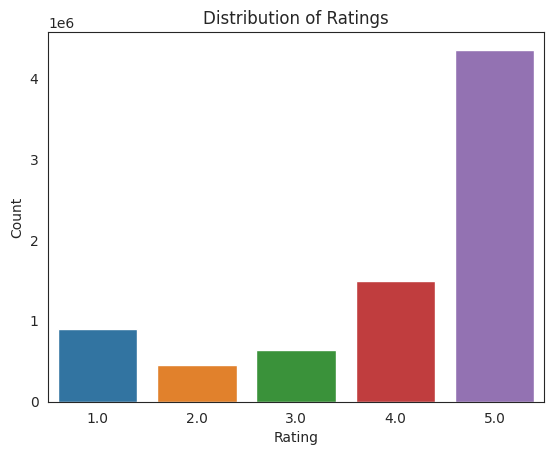

In [ ]:
# distribution of ratings
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='rating', data=ratings_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()


<Axes: xlabel='productId'>

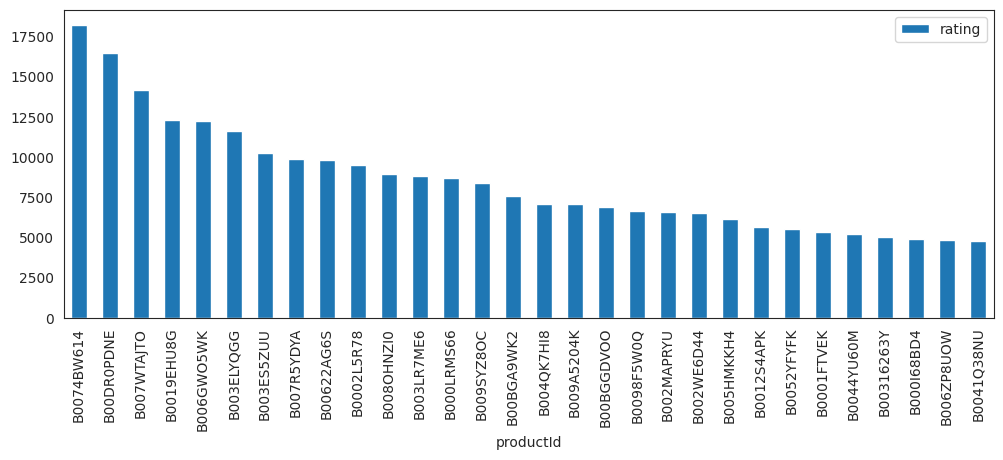

In [ ]:
# top 30 products
popular_products = pd.DataFrame(ratings_df.groupby('productId')['rating'].count())
most_popular = popular_products.sort_values('rating', ascending=False)
most_popular.head(30).plot(kind = "bar",figsize=(12, 4))

The final data frame will contain:
- 10,000 records
- users who have given 50 or more ratings

In [ ]:
# we will create a new dataframe which contains users who has given 50 or more ratings
ratings = ratings_df.groupby("productId").filter(lambda x:x['rating'].count() >= 50)
ratings.head()

,userId,productId,rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [ ]:
ratings.shape

(186327, 4)

## Recommender System Types

### Collaborative Filtering
---


In general, Collaborative filtering (CF) is more commonly used than content-based systems because it usually gives better results and is relatively easy to understand (from an overall implementation perspective). CF is based on the idea that the best recommendations come from people who have similar tastes. In other words, it uses historical item ratings of like-minded people to predict how someone would rate an item.
Collaborative filtering recommends the set of items based on what is called the user-item interaction matrix. Here is how the user-item interaction matrix look likes.

In [ ]:
ratings_matrix = ratings.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)

In [ ]:
ratings_matrix.shape

(167080, 1044)

In [ ]:
# filtering users who have rated at least 0.5% of total products
min_prods_rated_by_user = int(len(ratings_matrix.columns) * 0.005)
ratings_matrix_filtered = ratings_matrix[ratings_matrix.ne(0).sum(axis=1) >= min_prods_rated_by_user]
ratings_matrix_filtered.shape

(515, 1044)

In [ ]:
ratings_matrix_filtered

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00009V2PG,B00009V332,B00009V39N,B00009V3CG,B00009V3TT,B00009V4G9,B00009V6U0,B00009V7MU,B00009VQJ7,B00009VQJZ
userId,,,,,,,,,,,,,,,,,,,,,
A105TOJ6LTVMBG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10HSMHBTT0GWI,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10KZY39SVHUXD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A10MVOFKTZVNN4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A11AITBLOF0FE,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYWIO6OYAGFGQ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AYZMJYCRIZWIO,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZ0SIZRQWN7RC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# filtering products rated by at least 10 users
ratings_matrix_filtered = ratings_matrix_filtered.loc[:, ratings_matrix_filtered.count() >= 10]
ratings_matrix_filtered.shape

(515, 1044)

#### User-based CF

In [ ]:
# get each user's average rating on rated products, axis=1, calcualtion along every row
user_mean = ratings_matrix_filtered.mean(axis=1, skipna=True)

# get each product's average rating from the rating matrix, axis=0, calculation along each column
prod_mean = ratings_matrix_filtered.mean(axis=0, skipna=True)

# verify the shape of averaging results
user_mean.shape, prod_mean.shape

((515,), (1044,))

In [ ]:
# subtract the user average rating
# each row subtract the average rating from the corresponding user
ratings_matrix_adj = ratings_matrix_filtered - np.array(user_mean)[:, np.newaxis]

In [ ]:
ratings_matrix_adj

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00009V2PG,B00009V332,B00009V39N,B00009V3CG,B00009V3TT,B00009V4G9,B00009V6U0,B00009V7MU,B00009VQJ7,B00009VQJZ
userId,,,,,,,,,,,,,,,,,,,,,
A105TOJ6LTVMBG,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,...,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157
A10HSMHBTT0GWI,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,...,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946
A10KZY39SVHUXD,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,...,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452
A10MVOFKTZVNN4,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,...,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904
A11AITBLOF0FE,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,...,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYWIO6OYAGFGQ,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,...,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778
AYZMJYCRIZWIO,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,...,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989
AZ0SIZRQWN7RC,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,...,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778


In [ ]:
def get_neighbors(matrix, target_user=1, threshold=0.8):

    # get the boolean mask of products rated by the target user
    mask1 = ~matrix.loc[target_user].isnull()

    # create list to save similarity score of each pair of users
    sims = []

    # iterate over each row in the rating matrix
    for i, row in matrix.iterrows():

        # Skip the target user
        if i == target_user:
            continue

        # get the boolean mask for other users rated products
        mask2 = ~row.isnull()

        # get the mask of products rated by both users
        mask = mask1 & mask2

        # If less than 2 common products, skip this user
        if mask.sum() < 2:
            continue

        # get two vectors of product ratings, the products have been rated by both users
        v1 = np.array(matrix.loc[target_user][mask])
        v2 = np.array(row[mask])

        # calculate similarity based on Pearson correlation
        # (since the vectors are already centered, Pearson correlation is same as cosine similarity)
        sim = v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

        # check if similarity score is above threshold
        if sim < threshold:
            continue

        # organize the similarity of each pair of users
        # [(target user, user id in iteration), similarity score]
        comb = [(target_user, i), sim]

        # append it to the list
        sims.append(comb)

    # sort the list by similarity score, descending order
    sims = sorted(sims, key=lambda x: x[1], reverse=True)

    return sims


In [ ]:
def get_predictions(matrix, similarity_score, product_id, thres = 0.8, target_user = 600):

    # based on the prediction formula
    # default numerator and denominator as 0
    up = 0
    down = 0
    count = 0

    # iterate over the similarity score of each user pair
    for sim in similarity_score:

        # filter similarity score based on threshold
        if sim[1]>=thres:

            # get neighbor user id
            neighbor_id = sim[0][1]
            # get similarity score
            sim_score = sim[1]
            # get the mean-center rating of neighbor user on target product
            rate = matrix.loc[neighbor_id][product_id]

            # if no rating, go through next iteration
            if np.isnan(rate):
                continue
            # if rating provided, add values to numerator and denominator
            else:
                up += sim_score*rate
                down += sim_score
                count += 1

    # return weighted product from mean-centered rating matrix
    # and add target user average rating back in the prediction
    return (up/down + user_mean.loc[target_user]), count

In [ ]:
ratings_matrix_adj

productId,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,1400532736,1400599997,1400698987,...,B00009V2PG,B00009V332,B00009V39N,B00009V3CG,B00009V3TT,B00009V4G9,B00009V6U0,B00009V7MU,B00009VQJ7,B00009VQJZ
userId,,,,,,,,,,,,,,,,,,,,,
A105TOJ6LTVMBG,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,...,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157,-0.019157
A10HSMHBTT0GWI,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,...,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946,-0.023946
A10KZY39SVHUXD,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,...,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452,-0.012452
A10MVOFKTZVNN4,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,...,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904,-0.024904
A11AITBLOF0FE,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,...,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031,-0.022031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AYWIO6OYAGFGQ,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,...,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778
AYZMJYCRIZWIO,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,...,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989,-0.022989
AZ0SIZRQWN7RC,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,...,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778,-0.027778


In [ ]:
# get the similarity score of each user with user_id=A00570163ATHRHPDG3GKN from the rating matrix
sims_user_A105TOJ6LTVMBG = get_neighbors(ratings_matrix_adj, "A105TOJ6LTVMBG", 0.1)
sims_user_A105TOJ6LTVMBG

[[('A105TOJ6LTVMBG', 'A1D9V11QUHXENQ'), 0.276097627096572],
 [('A105TOJ6LTVMBG', 'A1NZLRAZJGD99W'), 0.25839087754872275],
 [('A105TOJ6LTVMBG', 'A36ARO7W03JMXV'), 0.2311048781451728],
 [('A105TOJ6LTVMBG', 'A15KFU3ZSAOUG0'), 0.21900398051549347],
 [('A105TOJ6LTVMBG', 'A3EV8JA23IUP7O'), 0.21241813366463916],
 [('A105TOJ6LTVMBG', 'A3NWP4CG5S2PDE'), 0.20381372437580617],
 [('A105TOJ6LTVMBG', 'A1KJRNFAO7K5S5'), 0.20381372437580614],
 [('A105TOJ6LTVMBG', 'A3J8A5L5AF5TX9'), 0.1850852536779918],
 [('A105TOJ6LTVMBG', 'ABU4LUKJU2QOY'), 0.17826696763987795],
 [('A105TOJ6LTVMBG', 'A204ETWOV23HO4'), 0.17798624480053649],
 [('A105TOJ6LTVMBG', 'A2HRHF83I3NDGT'), 0.16430848530915465],
 [('A105TOJ6LTVMBG', 'A3L9NGPTBJBQEL'), 0.13476851203850645],
 [('A105TOJ6LTVMBG', 'AJTYN2L8T5FER'), 0.12180648861372413],
 [('A105TOJ6LTVMBG', 'A14JBDSWKPKTZA'), 0.11732455267890543],
 [('A105TOJ6LTVMBG', 'A23GFTVIETX7DS'), 0.11301974768541943],
 [('A105TOJ6LTVMBG', 'A2MCPGNK2BKDU'), 0.10529301352973641],
 [('A105TOJ6LTV

In [ ]:
ratings_matrix_adj.loc["A105TOJ6LTVMBG"].value_counts()

-0.019157    1038
 4.980843       2
 3.980843       1
 2.980843       1
 0.980843       1
 1.980843       1
Name: A105TOJ6LTVMBG, dtype: int64

In [ ]:
ratings_matrix_adj.loc["A1D9V11QUHXENQ"].value_counts()

-0.021073    1039
 4.978927       3
 3.978927       1
 2.978927       1
Name: A1D9V11QUHXENQ, dtype: int64

##### Get predictions for User-based CF, user A105TOJ6LTVMBG, item 3


In [ ]:
pred_8 = get_predictions(ratings_matrix_adj, sims_user_A105TOJ6LTVMBG, 3, 0.08, "A105TOJ6LTVMBG")
pred_8


(-0.008691551271196928, 17)

#### Item-based CF

In [ ]:
def get_similar_products(matrix, target_product_id=216, min_common_users=2):
    # get the boolean mask of users who rated the target product
    mask1 = ~matrix[target_product_id].isnull()

    # create list to save similarity score of each pair of products
    sims = []

    # iterate over each column in the rating matrix
    for i in matrix.columns:
        # Skip the target product
        if i == target_product_id:
            continue

        # get the boolean mask for users who rated this product
        mask2 = ~matrix[i].isnull()

        # get the mask of users who rated both products
        mask = mask1 & mask2

        # If less than 2 common users, skip this product
        if mask.sum() < 2:
            continue

        # get two vectors of product ratings, the products have been rated by both users
        v1 = np.array(matrix[target_product_id][mask])
        v2 = np.array(matrix[i][mask])

        # calculate similarity based on Pearson correlation
        sim = v1.dot(v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

        # organize the similarity of each pair of products
        comb = [(target_product_id, i), sim]

        # append it to the list
        sims.append(comb)

    # sort the list by similarity score, descending order
    sims = sorted(sims, key=lambda x: x[1], reverse=True)

    return sims


In [ ]:
def get_prod_prediction(matrix, similarity_score, user_id, thres=0.8, target_product_id=216):
    # Initialize numerator, denominator, and count
    up = 0
    down = 0
    count = 0

    # Iterate over the similarity scores of each product pair
    for sim in similarity_score:
        # Filter similarity score based on the threshold
        if sim[1] >= thres:
            # Get similar product id and similarity score
            similar_product_id = sim[0][1]
            sim_score = sim[1]

            # Get the mean-centered rating of the user on the similar product
            rate = matrix.loc[user_id][similar_product_id]

            # If no rating, skip to the next iteration
            if np.isnan(rate):
                continue

            # If rating provided, add values to numerator and denominator
            up += sim_score * rate
            down += sim_score
            count += 1

    # Check if the denominator is zero
    if down == 0:
        return None, count  # Return None or any other appropriate value indicating no prediction

    # Calculate the predicted rating by dividing the numerator by the denominator
    predicted_rating = (up / down) + prod_mean.loc[target_product_id]
    return predicted_rating, count


In [ ]:
ratings_matrix_adj["0972683275"]

userId
A105TOJ6LTVMBG   -0.019157
A10HSMHBTT0GWI   -0.023946
A10KZY39SVHUXD   -0.012452
A10MVOFKTZVNN4   -0.024904
A11AITBLOF0FE    -0.022031
                    ...   
AYWIO6OYAGFGQ    -0.027778
AYZMJYCRIZWIO    -0.022989
AZ0SIZRQWN7RC    -0.027778
AZ4352XO4HH3M    -0.020115
AZMY6E8B52L2T    -0.023946
Name: 0972683275, Length: 515, dtype: float64

In [ ]:
# get the similarity score of each product with product_id=1400501776 from the rating matrix
sims_prod_1400501776 = get_similar_products(ratings_matrix_adj, "1400501776")
sims_prod_1400501776[:10]

[[('1400501776', '1400501520'), 1.0000000000000002],
 [('1400501776', '1400698987'), 0.9991994401297314],
 [('1400501776', '1400501466'), 0.7082787748322186],
 [('1400501776', '140053271X'), 0.47894027239516235],
 [('1400501776', '1400532620'), 0.13591960375610387],
 [('1400501776', '3744295508'), 0.13591960375610387],
 [('1400501776', '6301977173'), 0.13591960375610387],
 [('1400501776', '7214047977'), 0.13591960375610387],
 [('1400501776', '8862935293'), 0.13591960375610387],
 [('1400501776', '9573212919'), 0.13591960375610387]]

In [ ]:
prod_pred_8 = get_prod_prediction(ratings_matrix_adj, sims_prod_1400501776, "A105TOJ6LTVMBG", 0.8,"1400501776")


In [ ]:
prod_pred_8

(-0.00944835025852769, 2)

### Model-Based Collaborative Filtering
---


These methods are based on machine learning and data mining techniques. The goal is to train models to be able to make predictions. For example, we could use existing user-item interactions to train a model to predict the top-5 items that a user might like the most. One advantage of these methods is that they are able to recommend a larger number of items to a larger number of users, compared to other methods like memory based approach. They have large coverage, even when working with large sparse matrices.

#### Popularity Measure

In [ ]:
ratings_matrix = ratings.pivot_table(values='rating', index='userId', columns='productId', fill_value=0)

the utility matrix above is sparce, so we filled up the unknown values wth 0.

In [ ]:
ratings_matrix.shape

(167080, 1044)

In [ ]:
X = ratings_matrix.T
X.head()

userId,A00124802J36AVPT3779A,A00570163ATHRHPDG3GKN,A00625243BI8W1SSZNLMD,A0072193KFP6LUHKEXLT,A00988692Q9ZDJUD8BQSM,A00995931BE16NG4F52QC,A01035471LBTPFWCOKAU2,A014623426J5CM7M12MBW,A01852072Z7B68UHLI5UG,A01908602S6VC52FKCBA,...,AZZP8BC9WE0N8,AZZQFCVCFE8HL,AZZSCU0QYNQQ6,AZZST8OYL5P4Q,AZZUBI2MEAHI9,AZZUDVKC0E2XU,AZZUQYE2C1LNI,AZZX23UGJGKTT,AZZYWDOD33FFE,AZZZEWADNFNUM
productId,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501520,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X.shape

(1044, 167080)

In [ ]:
# unique products in subset of data
X1 = X

In [ ]:
# decomposing the matrix
from sklearn.decomposition import TruncatedSVD
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(1044, 10)

In [ ]:
# correlation Matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(1044, 1044)

In [ ]:
X.index[75]

'B00000K135'

In [ ]:
# Index # of product ID purchased by customer

i = "B00000K135"

product_names = list(X.index)
product_ID = product_names.index(i)
product_ID

75

Correlation for all items with the item purchased by this customer based on items rated by other customers people who bought the same product

In [ ]:
correlation_product_ID = correlation_matrix[product_ID]
correlation_product_ID.shape

(1044,)

Recommending top 25 highly correlated products in sequence

In [ ]:
Recommend = list(X.index[correlation_product_ID > 0.65])
# removes the item already bought by the customer
Recommend.remove(i)

Recommend[0:10]

['9575871979',
 '9983891212',
 'B00000J1V5',
 'B00000J3UJ',
 'B00000J434',
 'B00000K13A',
 'B000021YUO',
 'B000031KIM',
 'B00003CWDG',
 'B00004RC2E']

Here are the top 10 products to be displayed by the recommendation system to the above customer based on the purchase history of other customers in the website.

### SVD in surprise

[Matrix Factorization-based algorithms](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

The `SVD` implemented in `Surprise` module is different from the one before. This is a modified verison SVD, named **"Funk's SVD"**. The modified SVD only takes into account the rated values, ignoring whatever items have not beed rated by users.

The algorithm is named after Simon Funk, who was part of the team who placed 3rd in the Netflix challenge with this innovative way of performing matrix decomposition. Read more about Funk's SVD implementation at his original [blog](https://sifter.org/%7Esimon/journal/20061211.html).

In [ ]:
from surprise import SVD
svd = SVD()
reader = Reader()

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'productId', 'rating']], reader)

In [ ]:
# run 5-fold cross-validation and print the result
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2580  1.2479  1.2555  1.2571  1.2499  1.2537  0.0041  
MAE (testset)     0.9861  0.9799  0.9848  0.9853  0.9825  0.9837  0.0023  
Fit time          3.05    2.20    2.65    2.94    2.83    2.73    0.30    
Test time         0.19    0.18    0.17    0.26    0.17    0.20    0.04    


{'test_rmse': array([1.25802522, 1.2478875 , 1.25550481, 1.25711455, 1.24985779]),
 'test_mae': array([0.98610594, 0.97988381, 0.98478717, 0.98530309, 0.98245417]),
 'fit_time': (3.0520336627960205,
  2.19551157951355,
  2.65301775932312,
  2.943254232406616,
  2.8302254676818848),
 'test_time': (0.1899704933166504,
  0.18050432205200195,
  0.1735248565673828,
  0.2643139362335205,
  0.16840410232543945)}

As we can see, the mean Root Mean Sqaure Error of 1.25 approx. Let's now train on our dataset and arrive at predictions.

In [ ]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
# look at ratings by user 'A1BKC6B7YHYTVV'
ratings[ratings['userId'] == 'A1BKC6B7YHYTVV']

,userId,productId,rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400


Let's test our algorithm and predict the score that might be given to the productId of '0970407998' by this specific userId.

In [ ]:
svd.predict(uid='A17HMM1M7T9PJ1', iid='0970407998', r_ui=None).est

4.15441487777349

The score is: 4.15441487777349

We conclude that our model predicts that userId of 'A17HMM1M7T9PJ1' will give 4.15 as the rating for productId of '0970407998'.

In [ ]:
# verify the above prediction
ratings[ratings['userId'] == 'A17HMM1M7T9PJ1']

,userId,productId,rating,timestamp
49793,A17HMM1M7T9PJ1,B00004THDE,4.0,1212537600
86482,A17HMM1M7T9PJ1,B000058BCQ,4.0,1200182400
227418,A17HMM1M7T9PJ1,B00007GQLS,5.0,1155081600
227983,A17HMM1M7T9PJ1,B00007GQLU,5.0,1323302400
285147,A17HMM1M7T9PJ1,B00009R6UI,5.0,1323561600
285792,A17HMM1M7T9PJ1,B00009R6VZ,4.0,1323475200


## Conclusions & Future Work
---


1. Content Based Filtering


In general, content-based focuses on the attributes of items and provides you with recommendations based on the similarities between them. We can use this approach to find similarities between each type of product item and rank the similarity score from highest to lowest and select product sets based on the number of recommendations we want to offer.

However, our datastet only contains information about the ratings, users, and products, without additional features about the products. A possible work-aorund is to assume that a high rating signifies likeness for a certain type of product and aply the approach based on user preferrences.



Limitaions: This approach would inherently be constrained by a user's prior interactions and ratings. It wouldn't offer users opportunities to discover new domains or product categories. Moreover, the recommendations would lack diversification as all users who have rated item 'X' highly would receive identical suggestions.




2. Hybrid Recommendation Systems

Hybrid Recommendation Systems
In the future, the hybrid recommendation system could be extended to incorporate content-based filtering techniques. Content-based filtering emphasizes item attributes and leverages similarity metrics to make recommendations. However, this approach necessitates additional item features beyond user ratings, which are currently the primary data source. One potential approach to address this limitation is to infer user preferences based on high ratings and apply content-based filtering accordingly.

Limitations:
This extension would still be contingent on users' past interactions and preferences, limiting its ability to introduce users to entirely new product domains. It might result in recommending similar products to users who have rated a particular item highly, potentially lacking diversification in recommendations.

3. Knowledge Based Recommendation Systems

Future endeavors in knowledge-based recommendation systems could involve augmenting the knowledge base with additional product attributes, specifications, and domain-specific information. This expansion would enable the system to make more informed recommendations across a broader spectrum of product categories. Additionally, integrating natural language processing (NLP) techniques to analyze unstructured data, such as product reviews and descriptions, could enhance the system's knowledge-driven capabilities.

Limitations:
Despite its potential for knowledge-driven recommendations, this approach is bound by the availability and quality of structured data. The system may encounter challenges when dealing with niche or less-documented product categories, where structured information is limited. Furthermore, the system may not capture nuanced user preferences that could be discerned from unstructured textual data.
